# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [76]:

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 

digits = load_digits()

In [3]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

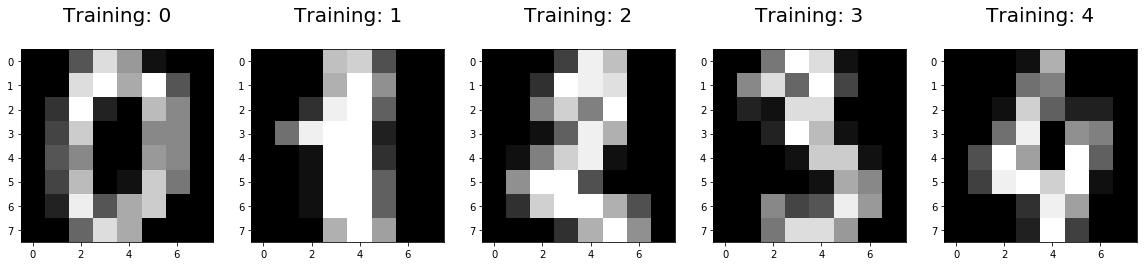

In [4]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

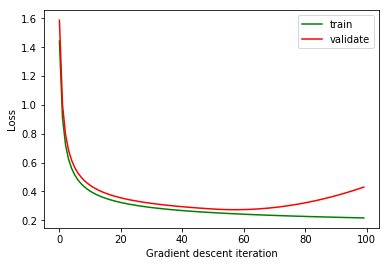

In [5]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [355]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp


X_train, X_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

## Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

### Приступим к реализации

Реализуем функции softmax и gradient (подсчет градиента) и log_loss (подсчет кросс-энтропии)

In [323]:
def softmax(y_pred):
    temp = np.exp(y_pred)
    return (temp / np.sum(temp, axis=1).reshape((temp.shape[0], 1)))

def log_loss(W, X, y):
    y_pred = X.dot(W)
    return (- y_pred[y==1] + np.log(np.sum(np.e ** (y_pred), axis=1))).mean()
    

def gradient(W, X, y):
    return (X.T).dot(softmax(X.dot(W)) - y) / X.shape[0]

Реализуем функцию градиентного спуска.

In [324]:
def gradientDescent(W, X_train, y_train, X_test, y_test, eta, n_iter):
    
    losses_train = []
    losses_test = []
    for i in tqdm.tqdm(range(n_iter)):
        grad = gradient(W, X_train, y_train)
        W = W - eta* grad
        losses_train.append(log_loss(W, X_train, y_train))
        losses_test.append(log_loss(W, X_test, y_test))
        
    return W, losses_train, losses_test
        

In [356]:
D = X_train.shape[1]
N = X_train.shape[0]
C = 10

W = np.random.randn(D, C) * 0.01
W = np.concatenate((W, np.zeros((1, C))))

X_train = np.concatenate((X_train, np.ones((N, 1))), axis=1)
X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)

In [326]:
print(D, N, C)

64 1203 10


In [327]:
eta = 1
n_iter = 5000
W_, losses_train, losses_test = gradientDescent(W.copy(), X_train, y_train, X_test, y_test, eta, n_iter)

100%|██████████| 5000/5000 [00:04<00:00, 1035.95it/s]


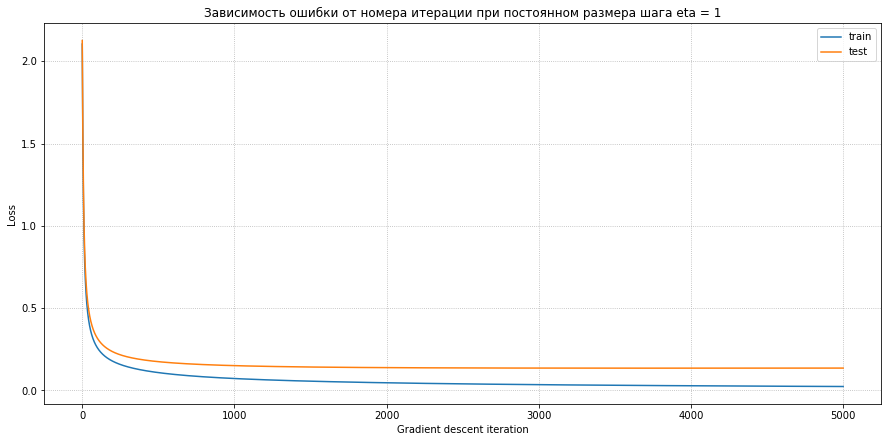

In [328]:
n_iters = len(losses_train)
plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iters), losses_train, label='train')
plt.plot(np.arange(n_iters), losses_test, label='test')
plt.title('Зависимость ошибки от номера итерации при постоянном размера шага eta = 1')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid(ls=':')
plt.legend()
plt.show()

In [329]:
print('Минимум функции ошибки для тестовой выборки достигается на {} итерации градиентного спуска'
      .format(np.argmin(np.array(losses_test))))

Минимум функции ошибки для тестовой выборки достигается на 3834 итерации градиентного спуска


Теперь посмотрим как будет сходиться градиентный спуск при выбранном eta = 100

In [360]:
eta = 100
n_iter = 150
W_, losses_train, losses_test = gradientDescent(W.copy(), X_train, y_train, X_test, y_test, eta, n_iter)

100%|██████████| 150/150 [00:00<00:00, 799.55it/s]


Построим аналогичный график ошибки.

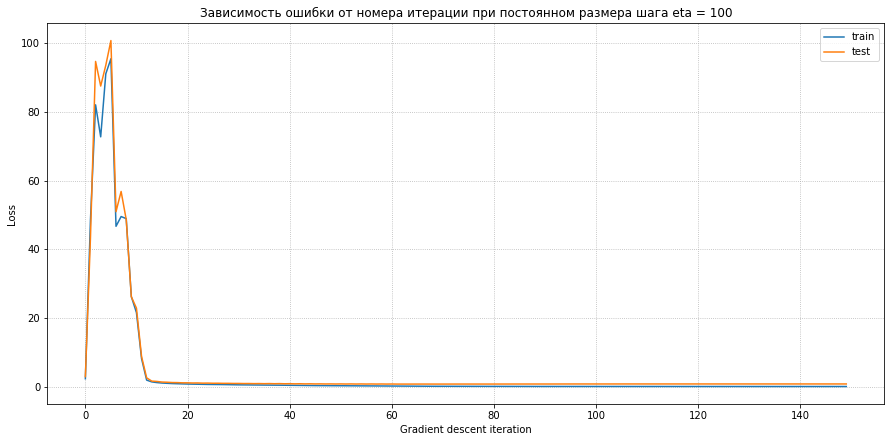

In [361]:
n_iters = len(losses_train)
plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iters), losses_train, label='train')
plt.plot(np.arange(n_iters), losses_test, label='test')
plt.title('Зависимость ошибки от номера итерации при постоянном размера шага eta = 100')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid(ls=':')
plt.legend()
plt.show()

In [406]:
def armijo(W, X, y, s, alpha=0.5, beta=0.5):
    grad = gradient(W, X, y)
    while log_loss(W - s*grad, X, y) > log_loss(W, X, y) - alpha * s * (np.linalg.norm(grad) **2):
        grad = gradient(W, X, y)
        s *= beta
    return s

In [449]:
def gradientDescentArmijo(W, X_train, y_train, X_test, y_test, n_iter):
    
    losses_train = []
    losses_test = []
    for i in tqdm.tqdm(range(n_iter)):
        grad = gradient(W, X_train, y_train)
        eta = armijo(W, X_train, y_train, 150, beta=0.7)
        W = W - eta* grad
        losses_train.append(log_loss(W, X_train, y_train))
        losses_test.append(log_loss(W, X_test, y_test))
        
    return W, losses_train, losses_test

In [490]:
n_iter = 300
W_, losses_train, losses_test = gradientDescentArmijo(W.copy(), X_train, y_train, X_test, y_test, n_iter)

100%|██████████| 300/300 [00:02<00:00, 127.87it/s]


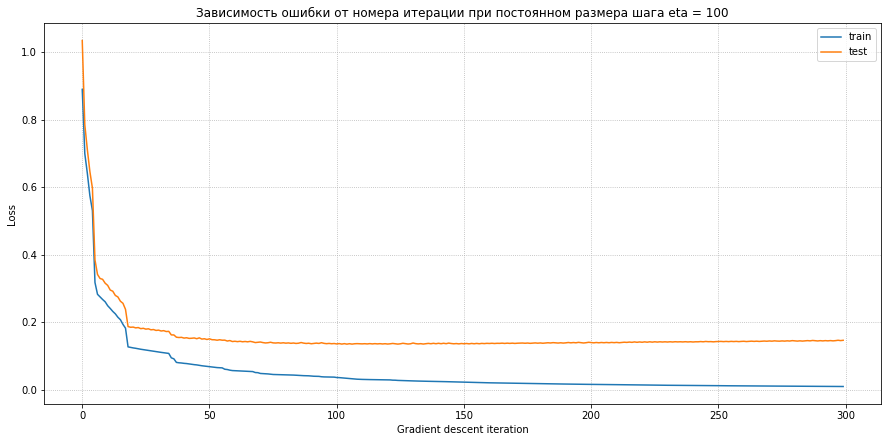

In [491]:
n_iters = len(losses_train)
plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iters), losses_train, label='train')
plt.plot(np.arange(n_iters), losses_test, label='test')
plt.title('Зависимость ошибки от номера итерации при постоянном размера шага eta = 100')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid(ls=':')
plt.legend()
plt.show()

In [21]:
def predict(W, X):
    y_pred = softmax(X.dot(W))
    return np.argmax(y_pred, axis=1)

#функция, возвращающая долю правильных ответов на выборке X
def accuracy(W, X, y):
    return (predict(W, X) == np.argmax(y, axis=1)).mean()

Посмотрим на результаты нашей работы 

In [519]:
print('Доля правильно предсказанных каринок на тестовой выборке: ', accuracy(W_, X_test, y_test))
print('Доля правильно предсказанных каринок на обучающей выборке: ', accuracy(W_, X_train, y_train))
print('Правильно предсказали {} картинки'.format((predict(W_, X_test) == np.argmax(y_test, axis=1)).sum()))
print('Неправильно предсказали {} картинки'.format((predict(W_, X_test) != np.argmax(y_test, axis=1)).sum()))

Доля правильно предсказанных каринок на тестовой выборке:  0.962962962963
Доля правильно предсказанных каринок на обучающей выборке:  1.0
Правильно предсказали 572 картинки
Неправильно предсказали 22 картинки
